# Nepremicnine.net

- regresija (napovedovanje cene nepremičnine)

### Namen

Namen raziskave je prepoznati kako podatki o številu kvadratnih metrov, lokaciji, letu gradnje, tipu ponudbe in številu sob vplivajo na ceno nepremičnine. Zanima nas tudi ali adaptacija nepremičnine vpliva na ceno nepremičnine. In ali tip nepremičnine (hiša/stanovanje) vpliva na ceno kvadratnega metra.
V tej raziskavi smo se osredotočili na dve glavni vrsti nepremičnin - stanovanje in hiše.

### Praktična uporaba

Ta model lahko uporabimo za postavitev cene novega oglasa nepremičnine glede na cene podobnih nepremičnin, ugotovitev povprečne cene/m2 v oglasih in primerjava s kasnejšo realizirano ceno prodaje. Ali pa kot obvestilo o novih oglasih, ki ustreazjo našim kriterijem ali pa imajo podpovprečne cene. Mailer bi bil še posebaj uporaben, ko bi kupovali novo nepremičnino in bi radi spremljali, ali se je pojavila kakšna nova nepremičnina, da bi bili lahko prvi, ki bi jo videli.

## Podatki

Podatke so pridobljeni z nepremičninskega portala [nepremicnine.net](https://www.nepremicnine.net/). Podatki uporabljeni v tem notebook-u so bili pridobljeni 22. 12. 2023, s pomočjo skripte, napisane v Node.js `scraper.js`.

Podatki so bili shranjeni v datoteko `scraped_results.csv`. Vsaka vrstica v datoteki predstavlja en oglas. Vrstice so ločene z novo vrstico `\n`, podatki v vrstici pa so ločeni z vejico `,`. Vrstica je sestavljena iz naslednjih podatkov:

- `id` - identifikacijska številka oglasa (po vrsti oštevilčen scrapan oglas)
- `tip` - tip oglasa (Stanovanje, Hiša, Posest, Vikend, Garaža, Poslovni prostor, Počitniški objekt)
- `st_sob` - število sob nepremičnine
- `lokacija` - lokacija nepremičnine (naslov oglasa z bolj ali manj točno lokacijo, ki lahko vsebuje mesto, četrt, ulico, ...)
- `m2` - število kvadratnih metrov nepremičnine, neto
- `leto_gradnje` - leto gradnje nepremičnine
- `leto_adaptacije` - leto adaptacije nepremičnine
- `tip_ponudbe` - tip ponudbe (zasebna ponudba ali ponudba s posredovanjem nepremičninske agencije)
- `cena` - cena nepremičnine v oglasu

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df = pd.read_csv("scraped_results.csv", sep=",", decimal=".")

df = df.drop(columns=["id"])

df.head()

,tip,st_sob,hisa_tip,lokacija,lokacija_podrobno,m2,leto_gradnje,leto_adaptacije,tip_ponudbe,cena
0,stanovanje,1.000,NaN,podravska,"TABOR, MARIBOR",32.00,1970,NaN,Zasebna,89.000
1,stanovanje,3.000,NaN,podravska,PLINTOVEC,74.00,2009,NaN,Agencija,235.000
2,stanovanje,3.000,NaN,podravska,VRANJI VRH,83.10,2010,2010,Zasebna,141.000
3,stanovanje,4.000,NaN,podravska,MARIBOR,141.10,2023,NaN,Agencija,317.591
4,stanovanje,4.000,NaN,podravska,ZGORNJA KUNGOTA,140.20,2023,NaN,Agencija,316.255


## Predprocesiranje


### Brisanje podatkov
Izbrišemo stolpec lokacija_podrobno, ker so podatki preveč raznoliki in ne enako podrobni.

Izbrišemo oglase (vrstice), ki nimajo podatka o ceni, saj niso uporabni za naš model.

In [2]:
df = df.drop(columns=["lokacija_podrobno"])

df = df.dropna(subset=["cena"])

Število manjkajočih podatkov.

In [3]:
df.isnull().sum()

tip                   0
st_sob              711
hisa_tip           1388
lokacija              0
m2                    0
leto_gradnje          0
leto_adaptacije    1436
tip_ponudbe           0
cena                  0
dtype: int64

Podatkovni tipi podatkov.

In [4]:
df.dtypes

tip                 object
st_sob             float64
hisa_tip            object
lokacija            object
m2                  object
leto_gradnje         int64
leto_adaptacije     object
tip_ponudbe         object
cena                object
dtype: object

Odstranjevanje znaka €.

Odstranjevanje prve pike v ceni (npr. 125.000.00 €).

In [5]:
df['leto_adaptacije'] = pd.to_numeric(df['leto_adaptacije'], errors='coerce')

df['cena'] = df['cena'].str.replace("€", "", regex=False)
df['cena'] = df['cena'].str.replace(".", "", regex=False)
df['cena'] = pd.to_numeric(df['cena'])

df['m2'] = df['m2'].str.replace(".", "", 1, regex=False)
df['m2'] = pd.to_numeric(df['m2'])
df['m2'] = df['m2'] / 100

df.dtypes

tip                 object
st_sob             float64
hisa_tip            object
lokacija            object
m2                 float64
leto_gradnje         int64
leto_adaptacije    float64
tip_ponudbe         object
cena                 int64
dtype: object

### Dopolnjevanje manjkajočih podatkov

Če je leto gradnje večje kot 2015 in manjka leto adaptacije, je leto adaptacije kar leto gradnje.

Ostale manjkajoče podatke o letu adaptacije pa napolnimo s povprečnim številom let.

In [6]:
df.loc[(df['leto_adaptacije'].isnull()) & (df['leto_gradnje'] > 2015), 'leto_adaptacije'] = df['leto_gradnje']

df['leto_adaptacije'] = df['leto_adaptacije'].fillna(df['leto_adaptacije'].mean())

Manjkajoče podatke o številu sob dopolnimo s povprečnim številom sob glede na kvadraturo nepremičnine.

Za vsako število sob izračunamo povprečno število kvadratnih metrov.

Na koncu oglasu brez tega podatka dodelimo število sob glede na kategorijo, ki mu je najbližje glede na povprečno število m2.

In [8]:
def izracunaj_povprecje(df, st_sob):
    return df[df['st_sob'] == st_sob]['m2'].mean()

avg_m2_per_st_sob = {}

for st_sob in df['st_sob'].unique():
    avg_m2 = izracunaj_povprecje(df, st_sob)
    avg_m2_per_st_sob[st_sob] = avg_m2


for index, row in df[df['st_sob'].isna()].iterrows():
    closest_st_sob = min(avg_m2_per_st_sob, key=lambda x: abs(avg_m2_per_st_sob[x] - row['m2']))
    df.at[index, 'st_sob'] = closest_st_sob

avg_m2_per_st_sob

{1.0: 34.954120967741936,
 3.0: 94.04399217221135,
 4.0: 138.95435096153844,
 2.0: 66.27232638888889,
 2.5: 71.01191489361702,
 1.5: 47.79081081081082,
 3.5: 104.98851851851852,
 5.0: 294.95508960573477,
 4.5: 175.0199193548387}

In [9]:
df.dtypes

tip                 object
st_sob             float64
hisa_tip            object
lokacija            object
m2                 float64
leto_gradnje         int64
leto_adaptacije    float64
tip_ponudbe         object
cena                 int64
dtype: object

In [10]:
df.isnull().sum()

tip                   0
st_sob                0
hisa_tip           1388
lokacija              0
m2                    0
leto_gradnje          0
leto_adaptacije       0
tip_ponudbe           0
cena                  0
dtype: int64

Opisna statistika številskih podatkov

In [11]:
df.describe()

,st_sob,m2,leto_gradnje,leto_adaptacije,cena
count,1954.000,1954.000,1954.000,1954.000,1954.000
mean,3.288,128.058,1976.875,2018.874,334935.030
std,1.145,92.803,67.775,6.653,272781.292
min,1.000,11.500,1015.000,1914.000,13900.000
25%,2.500,70.100,1962.000,2018.874,171250.000
50%,3.000,98.210,1990.000,2018.874,269900.000
75%,4.000,157.137,2023.000,2023.000,389000.000
max,5.000,948.000,2025.000,2025.000,3932029.000


## Vizualizacija podatkov

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

### Stolpični digram za število stanovanj in hiš v podatkovni množici

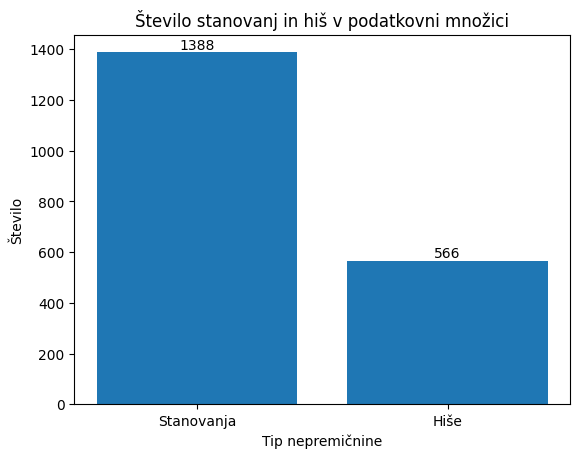

In [13]:
stevilo_stanovanj = df[df['tip'] == 'stanovanje'].shape[0]
stevilo_his = df[df['tip'] == 'hisa'].shape[0]

tipi_nepremicnin = ['Stanovanja', 'Hiše']
stevila = [stevilo_stanovanj, stevilo_his]

fig, ax = plt.subplots()
bars = plt.bar(tipi_nepremicnin, stevila)
plt.xlabel('Tip nepremičnine')
plt.ylabel('Število')
plt.title('Število stanovanj in hiš v podatkovni množici')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

### Heatmap številskih podatkov

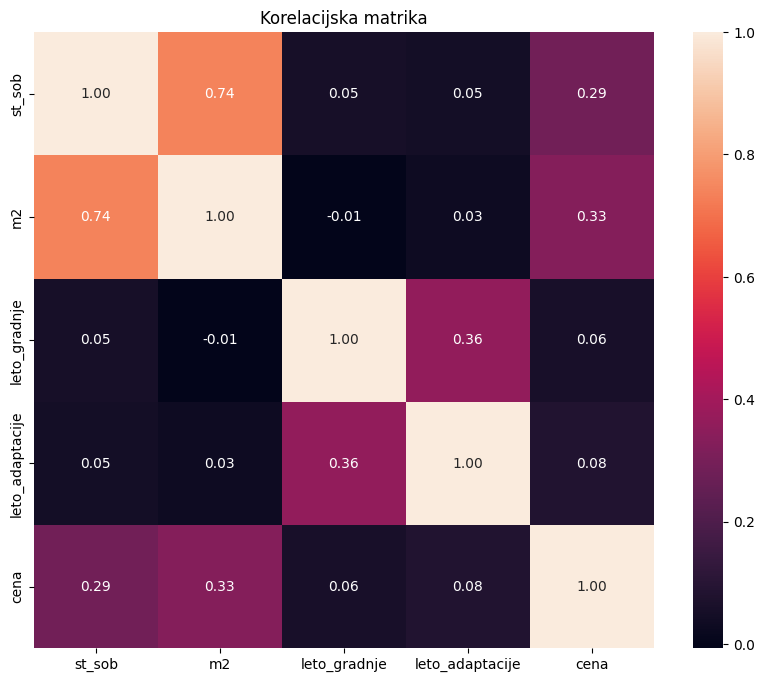

In [14]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Korelacijska matrika')
plt.show()

### Stolpični diagram za povprečno ceno na m2 za vse tipe nepremičnin

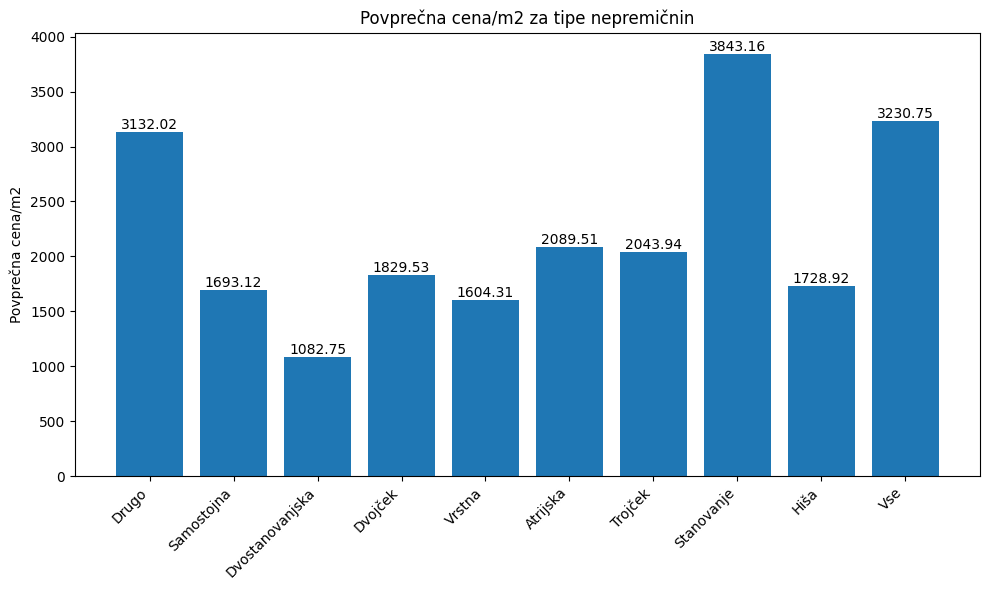

In [15]:
df['cena_na_m2'] = df['cena'] / df['m2']

stanovanje = df[df['tip'] == 'stanovanje']['cena_na_m2'].mean()

hisa = df[df['tip'] == 'hisa']['cena_na_m2'].mean()

hisa_tipi = df[df['tip'] == 'hisa']['hisa_tip'].unique()
cena_na_m2_po_tipih = {}

for tip in hisa_tipi:
    cena_na_m2_po_tipu = df[df['hisa_tip'] == tip]['cena_na_m2'].mean()
    cena_na_m2_po_tipih[tip] = cena_na_m2_po_tipu

povprecna_cena_na_m2_vse = df['cena_na_m2'].mean()

cena_na_m2_po_tipih['Stanovanje'] = stanovanje
cena_na_m2_po_tipih['Hiša'] = hisa
cena_na_m2_po_tipih['Vse'] = povprecna_cena_na_m2_vse
tipi = list(cena_na_m2_po_tipih.keys())
cene = list(cena_na_m2_po_tipih.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(tipi, cene)
plt.ylabel('Povprečna cena/m2')
plt.title('Povprečna cena/m2 za tipe nepremičnin')

for bar, cena_na_m2 in zip(bars, cene):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f'{cena_na_m2:.2f}', ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

df = df.drop(columns=['cena_na_m2'])

### Število oglasov po tipih hiš

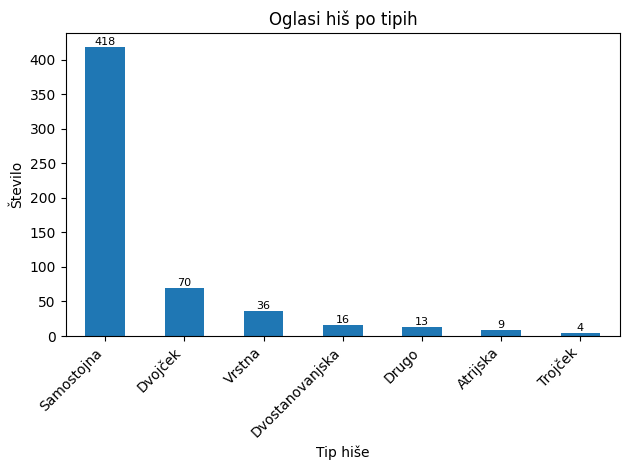

In [16]:
prodaja_tipov_his = df[df['tip'] == 'hisa']['hisa_tip'].value_counts()

ax = prodaja_tipov_his.plot(kind='bar')

for i, v in enumerate(prodaja_tipov_his):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=8)

plt.xlabel('Tip hiše')
plt.ylabel('Število')
plt.title('Oglasi hiš po tipih')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Število oglasov v podatkovni množici glede na število sob

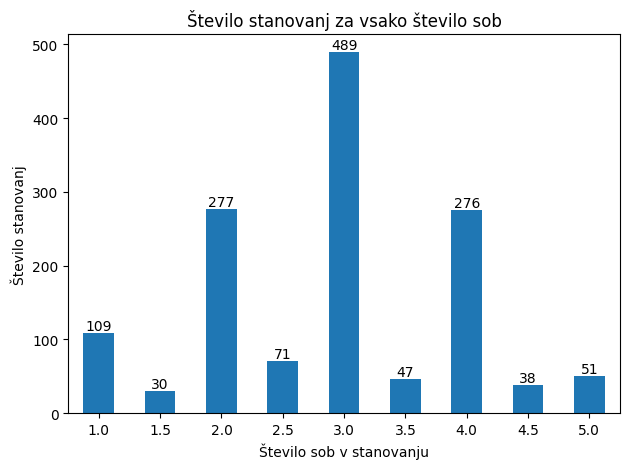

In [17]:
sobe_count = df[df['tip'] == 'stanovanje']['st_sob'].value_counts()

fig, ax = plt.subplots()
bars = sobe_count.sort_index().plot(kind='bar')

plt.xlabel('Število sob v stanovanju')
plt.ylabel('Število stanovanj')
plt.title('Število stanovanj za vsako število sob')
plt.xticks(rotation=0)
plt.tight_layout()

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

### Pregled tipov ponudb

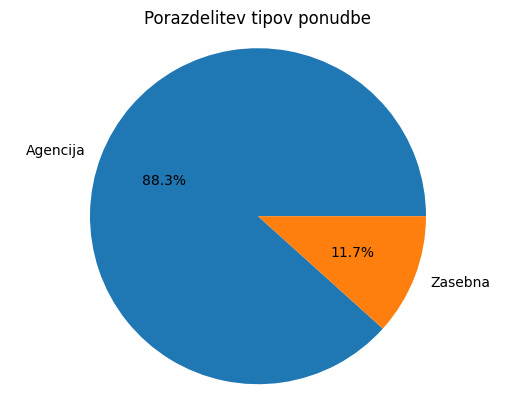

In [18]:
tip_ponudbe_count = df['tip_ponudbe'].value_counts()

plt.pie(tip_ponudbe_count, labels=tip_ponudbe_count.index, autopct='%1.1f%%')
plt.title('Porazdelitev tipov ponudbe')
plt.axis('equal')
plt.show()

### Histogram porazdelitve cen

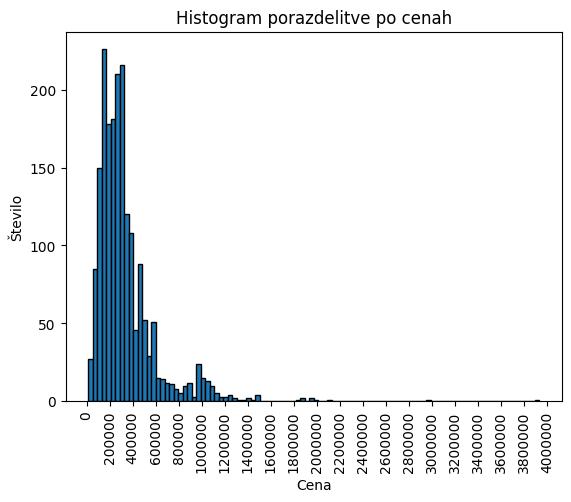

In [19]:
plt.hist(df["cena"], bins=100, edgecolor='black')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=30)
plt.xlabel('Cena')
plt.ylabel('Število')
plt.title('Histogram porazdelitve po cenah')
plt.show()

In [20]:
povprecje_sob = df[df['tip'] == 'stanovanje']['st_sob'].mean()
print(f"Povprečno število sob v stanovanjih: {povprecje_sob:.2f}")

Povprečno število sob v stanovanjih: 2.92


In [21]:
povprecje_leta_gradnje = df['leto_gradnje'].mean()
print(f"Povprečno leto gradnje: {povprecje_leta_gradnje:.2f}")

Povprečno leto gradnje: 1976.87


In [22]:
povprecna_cena_na_m2 = df['cena'] / df['m2']
povprecna_cena_na_m2 = povprecna_cena_na_m2[povprecna_cena_na_m2 < 1000]
print(f"Število stanovanj s ceno, manjšo od 1000€/m2: {povprecna_cena_na_m2.shape[0]}")

Število stanovanj s ceno, manjšo od 1000€/m2: 216


### Pretvorba kategoričnih podatkov v številske

In [23]:
df = pd.get_dummies(df, columns=["tip", "tip_ponudbe", "hisa_tip", "lokacija"])

df.head()

,st_sob,m2,leto_gradnje,leto_adaptacije,cena,tip_hisa,tip_stanovanje,tip_ponudbe_Agencija,tip_ponudbe_Zasebna,hisa_tip_Atrijska,hisa_tip_Drugo,hisa_tip_Dvojček,hisa_tip_Dvostanovanjska,hisa_tip_Samostojna,hisa_tip_Trojček,hisa_tip_Vrstna,lokacija_ljubljana-mesto,lokacija_podravska
0,1.000,32.000,1970,2018.874,89000,0,1,0,1,0,0,0,0,0,0,0,0,1
1,3.000,74.000,2009,2018.874,235000,0,1,1,0,0,0,0,0,0,0,0,0,1
2,3.000,83.100,2010,2010.000,141000,0,1,0,1,0,0,0,0,0,0,0,0,1
3,4.000,141.100,2023,2023.000,317591,0,1,1,0,0,0,0,0,0,0,0,0,1
4,4.000,140.200,2023,2023.000,316255,0,1,1,0,0,0,0,0,0,0,0,0,1


### Standardizacija številskih stolpcev

In [24]:
from sklearn.preprocessing import StandardScaler

numeric_columns = df.select_dtypes(include='number').columns
numeric_columns = numeric_columns.drop('cena')

scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

df.head()

,st_sob,m2,leto_gradnje,leto_adaptacije,cena,tip_hisa,tip_stanovanje,tip_ponudbe_Agencija,tip_ponudbe_Zasebna,hisa_tip_Atrijska,hisa_tip_Drugo,hisa_tip_Dvojček,hisa_tip_Dvostanovanjska,hisa_tip_Samostojna,hisa_tip_Trojček,hisa_tip_Vrstna,lokacija_ljubljana-mesto,lokacija_podravska
0,-1.998,-1.035,-0.101,0.000,89000,-0.639,0.639,-2.751,2.751,-0.068,-0.082,-0.193,-0.091,-0.522,-0.045,-0.137,-0.969,0.969
1,-0.251,-0.583,0.474,0.000,235000,-0.639,0.639,0.363,-0.363,-0.068,-0.082,-0.193,-0.091,-0.522,-0.045,-0.137,-0.969,0.969
2,-0.251,-0.485,0.489,-1.334,141000,-0.639,0.639,-2.751,2.751,-0.068,-0.082,-0.193,-0.091,-0.522,-0.045,-0.137,-0.969,0.969
3,0.622,0.141,0.681,0.620,317591,-0.639,0.639,0.363,-0.363,-0.068,-0.082,-0.193,-0.091,-0.522,-0.045,-0.137,-0.969,0.969
4,0.622,0.131,0.681,0.620,316255,-0.639,0.639,0.363,-0.363,-0.068,-0.082,-0.193,-0.091,-0.522,-0.045,-0.137,-0.969,0.969


### Delitev na učno in testno množico

In [25]:
X = df.drop(columns=['cena'], axis=1)
y = df['cena']

### Regresija

Izvedemo regresijo z različnimi vrstami regresorjev, pri čemer napovedujemo ceno.

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
}

def evaluate_model(model, X_train, y_train):
    mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mse_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    
    return mae_scores.mean(), r2_scores.mean(), mse_scores.mean()

###  Primerjava metrik regresije za različne regresorje

- MAE (Mean Absolute Error) - najboljši rezultati so tisti, ki so bližje vrednosti 0
- MSE (Mean Squared Error) - najboljši rezultati so tisti, ki so bližje vrednosti 0
- R2 (Coefficient of Determination) - najboljši rezultati so tisti, ki so bližje vrednosti 1 

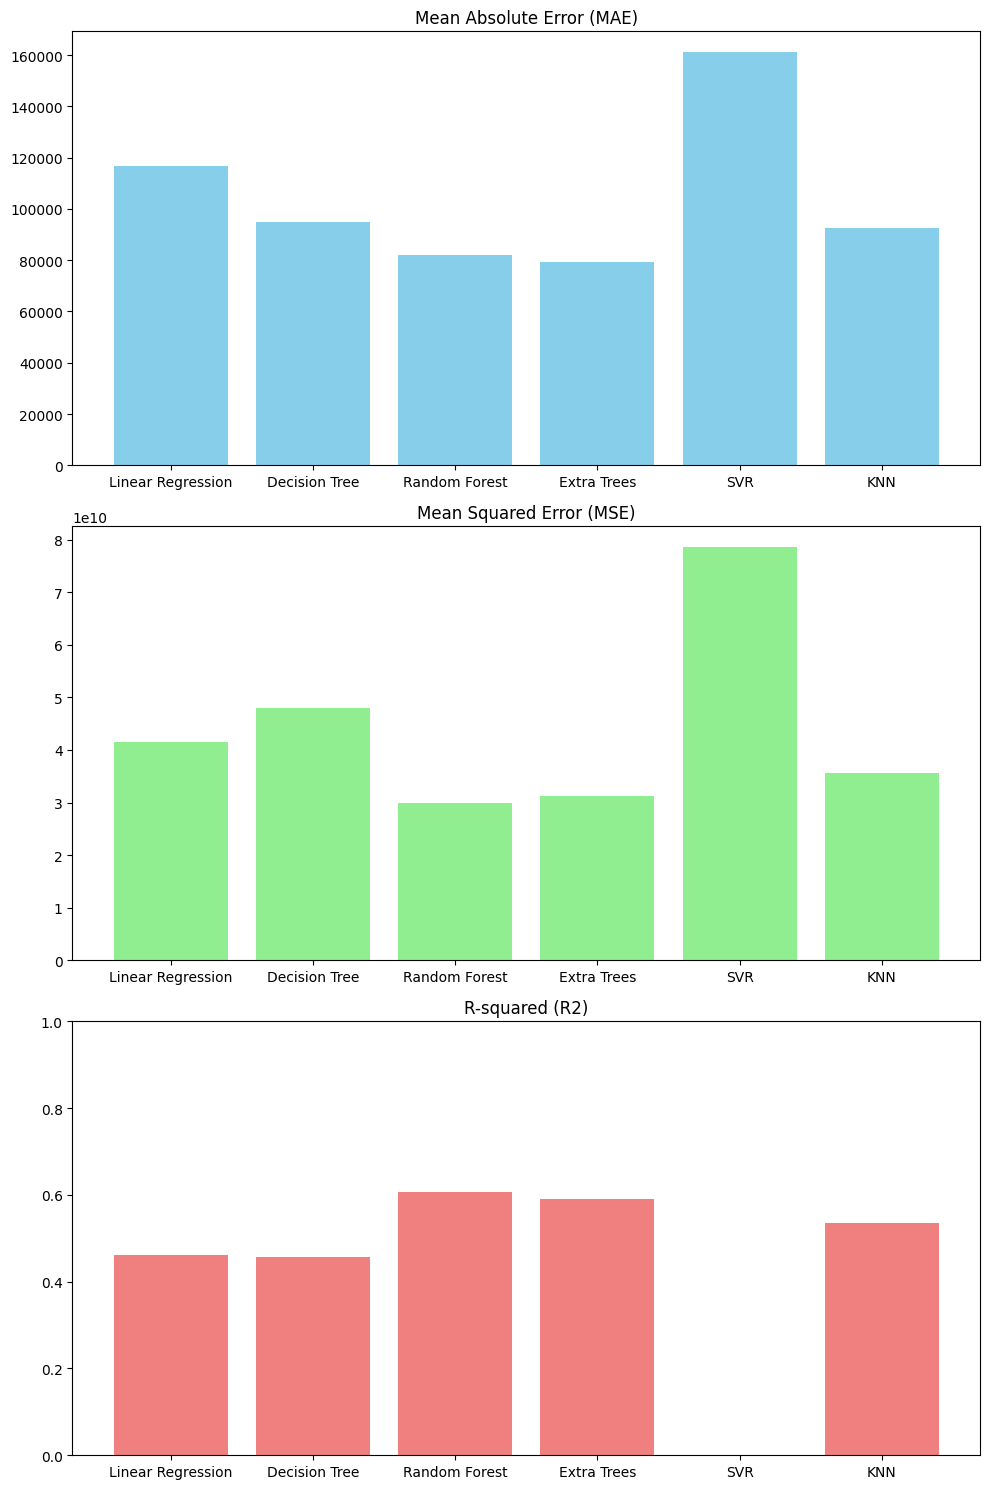

In [27]:
mae_results = []
mse_results = []
r2_results = []

for model_name, model in models.items():
    mae, r2, mse = evaluate_model(model, X_train, y_train)
    mae_results.append(mae)
    mse_results.append(mse)
    r2_results.append(r2)

fig, axes = plt.subplots(3, 1, figsize=(10, 15))

axes[0].bar(models.keys(), mae_results, color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)')

axes[1].bar(models.keys(), mse_results, color='lightgreen')
axes[1].set_title('Mean Squared Error (MSE)')

axes[2].bar(models.keys(), r2_results, color='lightcoral')
axes[2].set_title('R-squared (R2)')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

Iz grafov razberemo, da ceno najbolje napovedujeta `Random Forest` in `Extra Trees`.

Izpišimo nekaj dejanskih in napovedanih vrednosti cen Random Forest modela.

In [28]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
results_df = pd.DataFrame({'Dejansko': y_test, 'Napovedano': y_pred})

results_df

,Dejansko,Napovedano
1622,289000,244438.860
1736,90000,90721.000
978,158000,205139.900
1059,494607,431524.680
308,75000,60228.200
...,...,...
428,310998,296711.716
902,90000,120679.900
1820,139000,133772.000
1608,145000,101347.000


### Iskanje ustreznih nepremičnin in obveščanje

Med novimi nepremičninami (zadnjih 100) nas zanimajo npr. nepremičnine, ki imajo nizko ceno kvadratnega metra.

In [29]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df = pd.read_csv("scraped_results.csv", sep=",", decimal=".")
df = df.drop(columns=["id"])
df = df.dropna(subset=["cena"])
df['leto_adaptacije'] = pd.to_numeric(df['leto_adaptacije'], errors='coerce')
df['cena'] = df['cena'].str.replace("€", "", regex=False)
df['cena'] = df['cena'].str.replace(".", "", regex=False)
df['cena'] = pd.to_numeric(df['cena'])
df['m2'] = df['m2'].str.replace(".", "", 1, regex=False)
df['m2'] = pd.to_numeric(df['m2'])
df['m2'] = df['m2'] / 100


last_100 = df.head(100)
nizka_cena_na_m2 = last_100[last_100['cena'] / last_100['m2'] < 1500]

nizka_cena_na_m2

,tip,st_sob,hisa_tip,lokacija,lokacija_podrobno,m2,leto_gradnje,leto_adaptacije,tip_ponudbe,cena
33,stanovanje,3.000,NaN,podravska,ZGORNJA HAJDINA,114.900,1992,2015.000,Agencija,69000
46,stanovanje,3.000,NaN,podravska,"TABOR, ATRIJSKO",196.500,2023,NaN,Agencija,229245


Ali pa stanovanja v Ljubljani, ki stanejo manj kot 100.000€.

In [30]:
filtered = df[(df['cena'] < 100000) & (df['lokacija'].str.contains('Ljubljana|LJ|Lj|ljubljana', case=False))]
filtered

,tip,st_sob,hisa_tip,lokacija,lokacija_podrobno,m2,leto_gradnje,leto_adaptacije,tip_ponudbe,cena
506,stanovanje,NaN,NaN,ljubljana-mesto,JARŠE,26.800,1952,NaN,Agencija,97000
902,stanovanje,NaN,NaN,ljubljana-mesto,LJ. ŠIŠKA,17.000,1983,NaN,Zasebna,90000
954,stanovanje,NaN,NaN,ljubljana-mesto,NOVE JARŠE,26.800,1952,NaN,Agencija,97000
1122,stanovanje,NaN,NaN,ljubljana-mesto,"LJ. CENTER, BOHORIČEVA",31.600,1800,NaN,Agencija,99000
1128,stanovanje,NaN,NaN,ljubljana-mesto,LJ. ŠIŠKA,19.200,1983,NaN,Agencija,85000
1258,stanovanje,NaN,NaN,ljubljana-mesto,DRAVLJE,14.000,1982,NaN,Agencija,56000
1360,stanovanje,NaN,NaN,ljubljana-mesto,LJ. ŠIŠKA,14.000,1984,NaN,Agencija,65000


### Mailer

In [31]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_email(subject, html_body, to_email, smtp_server, smtp_port, sender_email, sender_password):
    message = MIMEMultipart()
    message['From'] = sender_email
    message['To'] = to_email
    message['Subject'] = subject

    message.attach(MIMEText(html_body, 'html'))

    # Povezava na SMTP server s SSL
    server = smtplib.SMTP_SSL(smtp_server, smtp_port)

    server.login(sender_email, sender_password)
    server.sendmail(sender_email, to_email, message.as_string())
    server.quit()


subject = "Nepremičnine, ki ustrezajo vašim kriterijem"
html_body = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
</head>
<body style="font-family: 'Arial', sans-serif; background-color: #f4f4f4; color: #333; margin: 0; padding: 0;">

    <div class="container" style="max-width: 600px; margin: 20px auto; background-color: #fff; padding: 20px; border-radius: 5px; box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);">

        <h1 style="color: #007BFF;">Pozdravljeni!</h1>

        <p style="line-height: 1.6;">Na <a href="https://www.nepremicnine.net/" style="color: #007BFF; text-decoration: none; font-weight: bold;">nepremicnine.net</a> so se pojavile nove nepremičnine, ki ustrezajo vašim kriterijem:</p>

        <table style="width: 100%; border-collapse: collapse; margin-top: 20px;">
            <tr style="border-bottom: 1px solid #ddd; background-color: #f2f2f2;">
                <th style="padding: 10px; text-align: left;">Nepremičnina</th>
                <th style="padding: 10px; text-align: left;">Cena</th>
                <th style="padding: 10px; text-align: left;">m2</th>
                <th style="padding: 10px; text-align: left;">Cena/m2</th>
                <th style="padding: 10px; text-align: left;">Tip ponudbe</th>
            </tr>
"""

for index, row in filtered.iterrows():
    html_body += f"""
            <tr style="border-bottom: 1px solid #ddd;">
                <td style="padding: 10px; text-align: left;">{row['lokacija'].capitalize()}</td>
                <td style="padding: 10px; text-align: left;">{row['cena']}€</td>
                <td style="padding: 10px; text-align: left;">{row['m2']} m2</td>
                <td style="padding: 10px; text-align: left;">{row['cena'] / row['m2']:.0f}€</td>
                <td style="padding: 10px; text-align: left;">{row['tip_ponudbe']}</td>
            </tr>
"""

html_body += """
        </table>

        <p style="line-height: 1.6;">Bodite prvi, ki si ogleda: <a href="url" style="color: #007BFF; text-decoration: none; font-weight: bold;"><a href="https://www.nepremicnine.net/">Nepremicnine.net</a></a></p>
        <p style="line-height: 1.6;">Lep pozdrav,<br>vaša ekipa</p>

    </div>

    <footer style="margin-top: 20px; text-align: center; font-size: 14px; color: #777;">
    <p style="margin: 0">Opozorilo: Cene se lahko spremenijo, nismo odgovorni za morebitne napake ali netočnosti.</p>
    </footer>

</body>
</html>
"""

to_email = "recipient@example.com"
smtp_server = "smtp.gmail.com"
smtp_port = 465
sender_email = "your_email@gmail.com"
sender_password = "your_password"

send_email(subject, html_body, to_email, smtp_server, smtp_port, sender_email, sender_password)

### Analiza rezultatov, ugotovitve

Ugotovili smo, da ljudje večinoma prodajajo nepremičnine z posredovanjem agencije in da je cena kvadratnega metra nepremičnine v povprečju zelo višja pri stanovanjih kot pri hišah. 

Največ stanovanj na trgu je 3-sobnih. Največ hiš je samostojnih.

Na ceno seveda najbolj vpliva število m2 in števil sob, kar je razvidno iz korelacijske matrike.

Pri regresiji se najbolje izkaže Random Forest Regressor, saj ima glede na ostale najboljše vrednosti metrik MAE, MSE in R2. Še vedno pa vidimo, da se model zmoti tudi za 20.000€ pri napovedovanju cene, kar je procentalno gledano veliko (npr. pri ceni 100.000€ je to 20%).

Zanimiva bi bila primerjava tržnih in realiziranih cen.

Za boljšo raziskavo bi morali vključiti še več podatkov (oglasov) nepremičnin iz drugih regij in lokacij.